In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import models
from torchvision import transforms as T
from PIL import Image

# Segmentacja obrazów

## FCN-ResNet101

In [2]:
model = models.segmentation.fcn_resnet101(pretrained=True).eval()

In [3]:
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [4]:
img = Image.open('PennFudanPed/PNGImages/FudanPed00074.png')

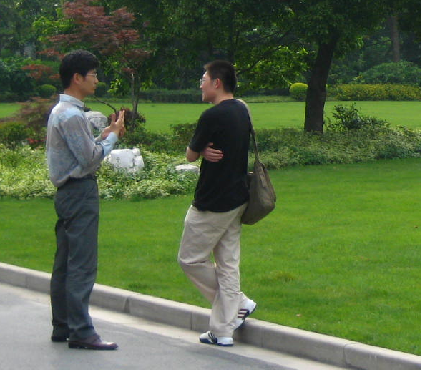

In [5]:
img

In [6]:
transform = T.Compose([
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
inp_img = transform(img).unsqueeze(0)

In [8]:
inp_img.shape

torch.Size([1, 3, 370, 421])

In [9]:
with torch.no_grad():
    out = model(inp_img)

In [10]:
out

OrderedDict([('out',
              tensor([[[[11.3487, 11.3487, 11.3487,  ..., 10.5210, 10.5210, 10.5210],
                        [11.3487, 11.3487, 11.3487,  ..., 10.5210, 10.5210, 10.5210],
                        [11.3487, 11.3487, 11.3487,  ..., 10.5210, 10.5210, 10.5210],
                        ...,
                        [ 9.5352,  9.5352,  9.5352,  ...,  8.5086,  8.5086,  8.5086],
                        [ 9.5352,  9.5352,  9.5352,  ...,  8.5086,  8.5086,  8.5086],
                        [ 9.5352,  9.5352,  9.5352,  ...,  8.5086,  8.5086,  8.5086]],
              
                       [[-1.1435, -1.1435, -1.1435,  ..., -0.6489, -0.6489, -0.6489],
                        [-1.1435, -1.1435, -1.1435,  ..., -0.6489, -0.6489, -0.6489],
                        [-1.1435, -1.1435, -1.1435,  ..., -0.6489, -0.6489, -0.6489],
                        ...,
                        [-0.3204, -0.3204, -0.3204,  ...,  1.0816,  1.0816,  1.0816],
                        [-0.3204, -0.3204, -0

In [11]:
out = out["out"]

In [12]:
out.shape

torch.Size([1, 21, 370, 421])

In [13]:
segments = torch.argmax(out.squeeze(), dim=0).numpy()

In [14]:
segments.shape

(370, 421)

In [15]:
np.unique(segments)

array([ 0, 15])

{ 0: background, 1: aeroplane, 2: bicycle, 3: bird, 4: boat, 5: bottle, 6: bus,   
&nbsp;&nbsp;7: car, 8: cat, 9: chair, 10: cow, 11: dining table, 12: dog, 13: horse,   
&nbsp;&nbsp;14: motorbike, 15: person, 16: potted plant, 17: sheep, 18: sofa, 19: train, 20: tv/monitor }

In [16]:
def decode_segment_map(image, nc=21):
    label_colors = np.array([(0, 0, 0), (128, 0, 0), (0, 128, 0), 
                             (128, 128, 0), (0, 0, 128), (128, 0, 128), 
                             (0, 128, 128), (128, 128, 128), (64, 0, 0), 
                             (192, 0, 0), (64, 128, 0), (192, 128, 0), 
                             (64, 0, 128), (192, 0, 128), (64, 128, 128), 
                             (192, 128, 128), (0, 64, 0), (128, 64, 0), 
                             (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for x in range(0, nc):
        idx = image == x
        r[idx] = label_colors[x, 0]
        g[idx] = label_colors[x, 1]
        b[idx] = label_colors[x, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return Image.fromarray(rgb) 

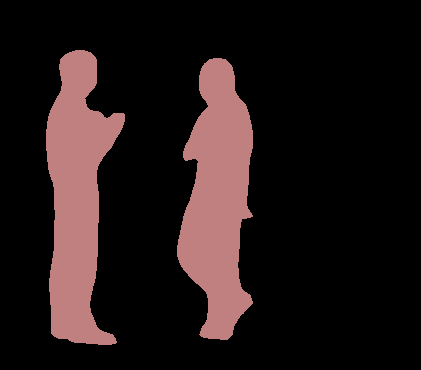

In [17]:
decode_segment_map(segments)

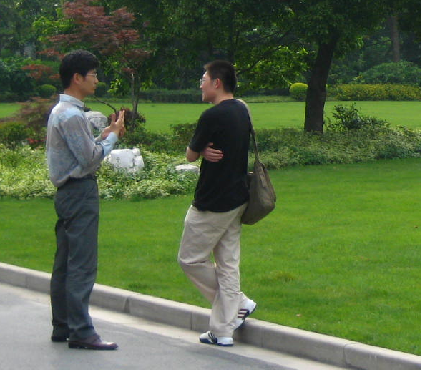

In [18]:
img

In [19]:
def segment(net, path):
    img = Image.open(path)
    trf = T.Compose([T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    inp_img = trf(img).unsqueeze(0)
    with torch.no_grad():
        out = net(inp_img)['out']
    segments = torch.argmax(out.squeeze(), dim=0).numpy()
    out_img = decode_segment_map(segments)
    return img, out_img

In [20]:
img, out_img = segment(model, "PennFudanPed/PNGImages/FudanPed00001.png")

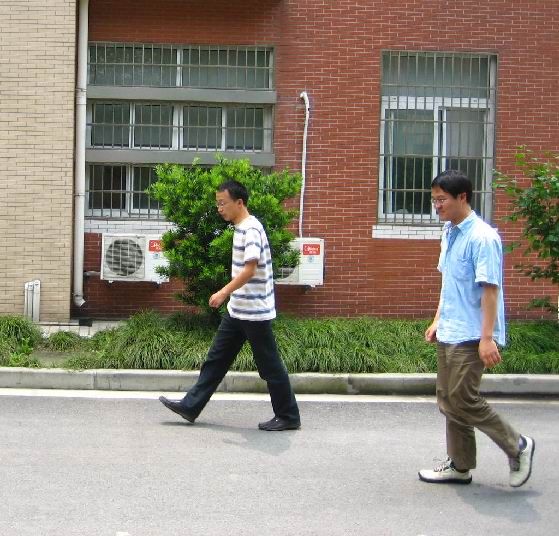

In [21]:
img

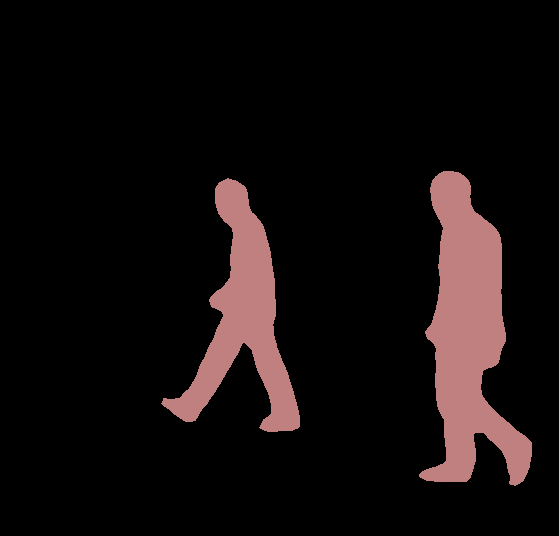

In [22]:
out_img

## DeepLabV3-ResNet101

In [23]:
dlab_model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

In [24]:
print(dlab_model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [25]:
img, out_img = segment(dlab_model, "PennFudanPed/PNGImages/FudanPed00001.png")

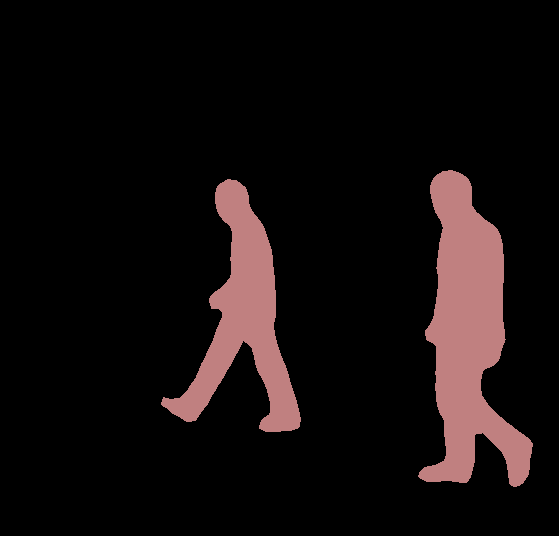

In [26]:
out_img

In [27]:
img, out_img = segment(dlab_model, "plane.jpg")

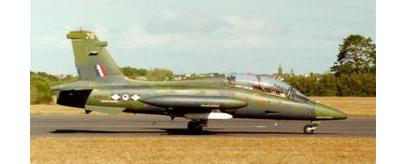

In [28]:
img

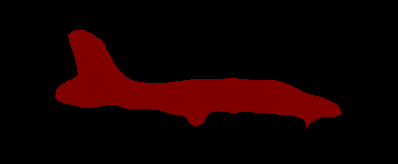

In [29]:
out_img

In [30]:
img, out_img = segment(dlab_model, "dog.jpg")

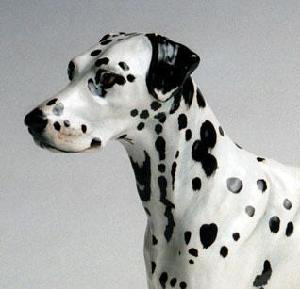

In [31]:
img

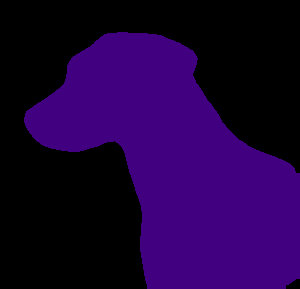

In [32]:
out_img

In [33]:
img, out_img = segment(dlab_model, "bird.jpg")

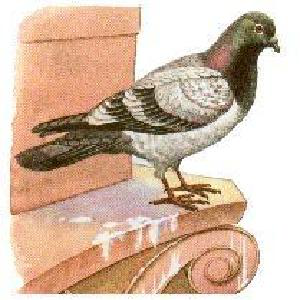

In [34]:
img

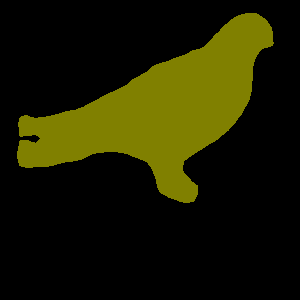

In [35]:
out_img

## Trenowanie sieci

https://github.com/pytorch/vision/tree/master/references/segmentation